# EIANN Tutorial 1

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt

# from EIANN._network import Network
import EIANN as eiann
import EIANN.utils as ut
import EIANN.plot as pt

pt.update_plot_defaults()
%load_ext autoreload
%autoreload 2

/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/utils/data_utils.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## 1. Load MNIST data

In [62]:
# Load dataset
tensor_flatten = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])
MNIST_train_dataset = torchvision.datasets.MNIST(root='../EIANN/data/mnist/datasets/MNIST_data/', train=True, download=True,
                                         transform=tensor_flatten)
MNIST_test_dataset = torchvision.datasets.MNIST(root='../EIANN/data/mnist/datasets/MNIST_data/',
                                        train=False, download=True, transform=tensor_flatten)

# Add index to train & test data
MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train_dataset):
    target = torch.eye(len(MNIST_train_dataset.classes))[target]
    MNIST_train.append((idx, data, target))
    
MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test_dataset):
    target = torch.eye(len(MNIST_test_dataset.classes))[target]
    MNIST_test.append((idx, data, target))
    
# Put data in dataloader
data_generator = torch.Generator()
train_dataloader = torch.utils.data.DataLoader(MNIST_train[0:50000], shuffle=True, generator=data_generator)
val_dataloader = torch.utils.data.DataLoader(MNIST_train[-10000:], batch_size=10000, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(MNIST_test, batch_size=10000, shuffle=False)

We can also build more complex "EI" networks with separate excitatory (E) and inhibitory (I) populations, where "Dale's law" (signed weights) is enforced for each population.

In [ ]:
network_config = eiann.NetworkBuilder()

# Define layers and populations
network_config.layer('Input').population('E', 784)
network_config.layer('H1').population('E', 500, 'relu').population('SomaI', 50, 'relu')
network_config.layer('H2').population('E', 500, 'relu').population('SomaI', 50, 'relu')
network_config.layer('Output').population('E', 10, 'linear').population('SomaI', 10, 'relu')

# Create connections between populations
network_config.connect(source='Input.E', target='H1.E').type('Exc')
network_config.connect(source='H1.E', target='H1.SomaI').type('Exc')
network_config.connect(source='H1.SomaI', target='H1.E').type('Inh').direction('R')

network_config.connect(source='H1.E', target='H2.E').type('Exc')
network_config.connect(source='H2.E', target='H2.SomaI').type('Exc')
network_config.connect(source='H2.SomaI', target='H2.E').type('Inh').direction('R')

network_config.connect(source='H2.E', target='Output.E').type('Exc')
network_config.connect(source='Output.E', target='Output.SomaI').type('Exc')
network_config.connect(source='Output.SomaI', target='Output.E').type('Inh').direction('R')

# Set global learning rule
network_config.set_learning_rule('Backprop')

# Set training parameters
network_config.training(optimizer='SGD',
                        tau=3,
                        forward_steps=15,
                        backward_steps=3,
                        learning_rate=0.0000001, 
                        verbose=False)


network_config.print_architecture()

# Build the network
network_seed = 42 # Random seed for network initialization (for reproducibility)
network = network_config.build(seed=network_seed)


Network Architecture:
Input.E (784) -> H1.E (500): Backprop
H1.SomaI (50) -> H1.E (500): Backprop
H1.E (500) -> H1.SomaI (50): Backprop
H1.E (500) -> H2.E (500): Backprop
H2.SomaI (50) -> H2.E (500): Backprop
H2.E (500) -> H2.SomaI (50): Backprop
H2.E (500) -> Output.E (10): Backprop
Output.SomaI (10) -> Output.E (10): Backprop
Output.E (10) -> Output.SomaI (10): Backprop
Network(
  (criterion): MSELoss()
  (module_dict): ModuleDict(
    (H1E_InputE): Projection(in_features=784, out_features=500, bias=False)
    (H1E_H1SomaI): Projection(in_features=50, out_features=500, bias=False)
    (H1SomaI_H1E): Projection(in_features=500, out_features=50, bias=False)
    (H2E_H1E): Projection(in_features=500, out_features=500, bias=False)
    (H2E_H2SomaI): Projection(in_features=50, out_features=500, bias=False)
    (H2SomaI_H2E): Projection(in_features=500, out_features=50, bias=False)
    (OutputE_H2E): Projection(in_features=500, out_features=10, bias=False)
    (OutputE_OutputSomaI): Projec

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/50 [00:00<?, ?it/s]

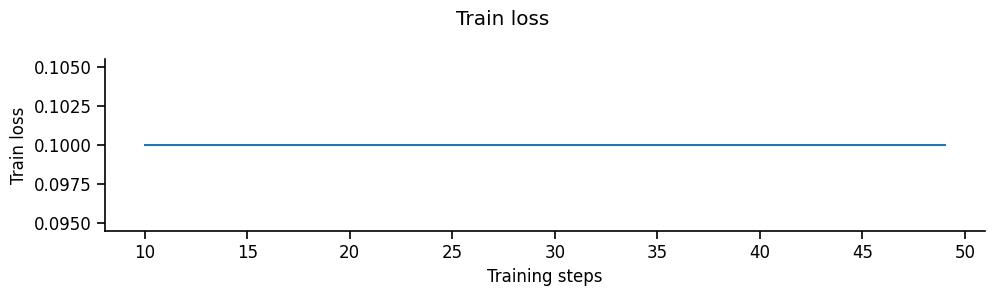

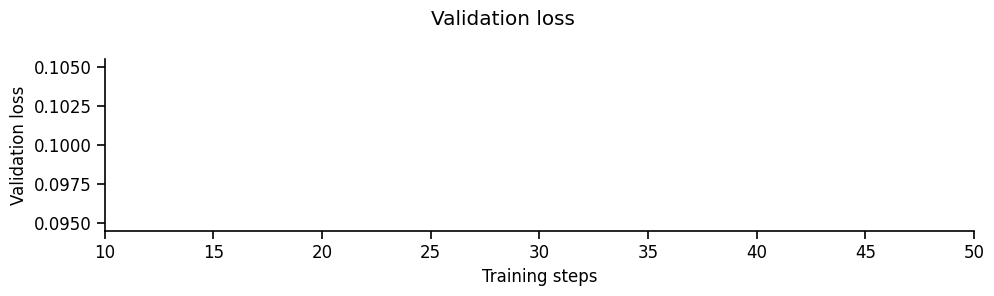

In [113]:
# Training parameters
# --------------------------
epochs = 1
train_steps = 50

# Train the network
# --------------------------
data_seed = 123 # Random seed for reproducibility. Ensures that the data is sampled in the same order each time.
data_generator.manual_seed(data_seed)
network.train(train_dataloader, val_dataloader, 
              samples_per_epoch=train_steps, 
              val_interval=(0, -1, 100),
              store_history=True,
              store_history_interval=(0, -1, 1),
              status_bar=True)

# Plot training results
# --------------------------
eiann.plot.plot_train_loss_history(network, train_step_range=(10, train_steps))
eiann.plot.plot_validate_loss_history(network, train_step_range=(10, train_steps))


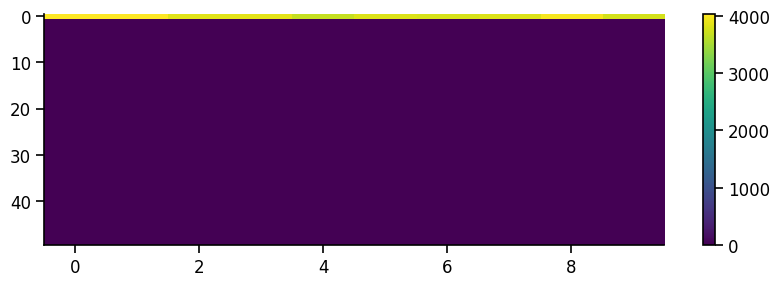

In [114]:
plt.imshow(network.Output.E.activity_history,aspect='auto', interpolation='none')
plt.colorbar()

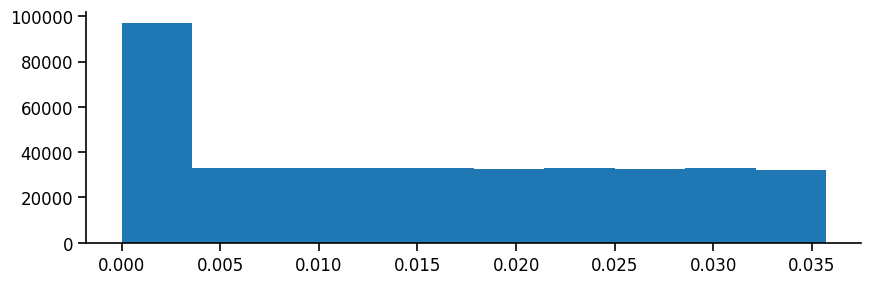

In [ ]:
d = plt.hist(network.projections['H1E_InputE'].weight.data.flatten())

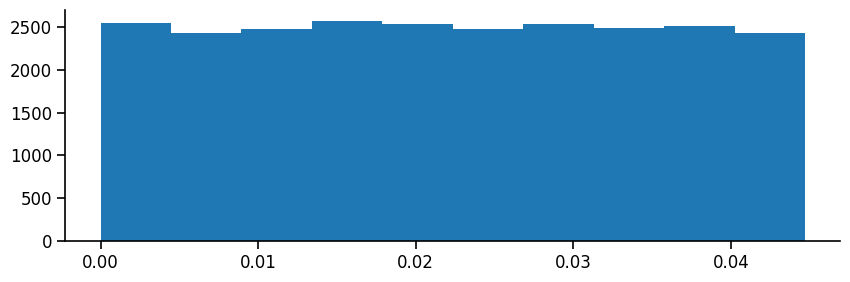

In [38]:
d = plt.hist(network.projections['H1SomaI_H1E'].weight.data.flatten())

In [39]:
d = plt.hist(network.projections['H1E_H1SomaI'].weight.data.flatten())

KeyError: 'H1E_H1SomaI'

Batch accuracy = 9.800000190734863%


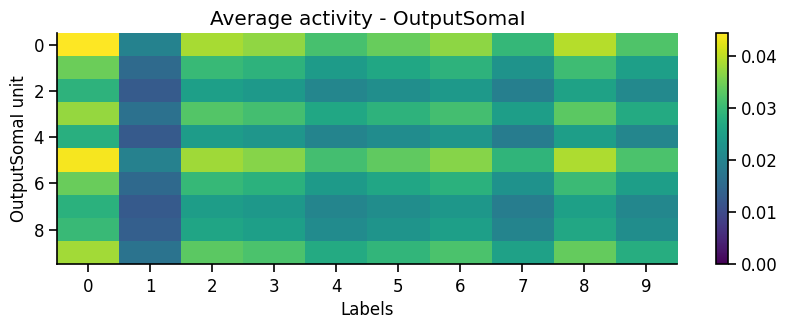

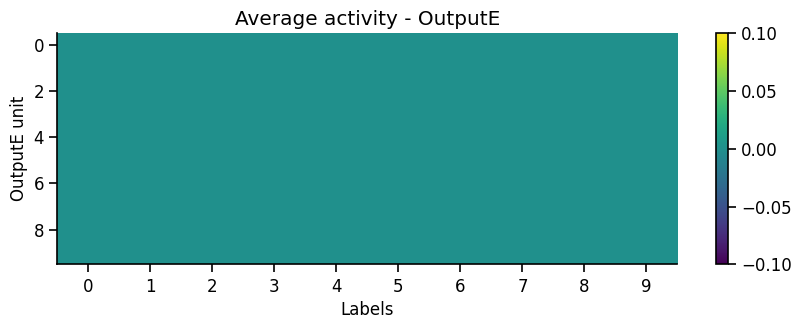

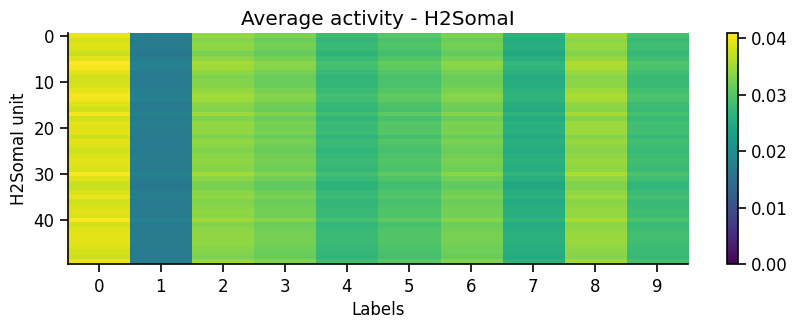

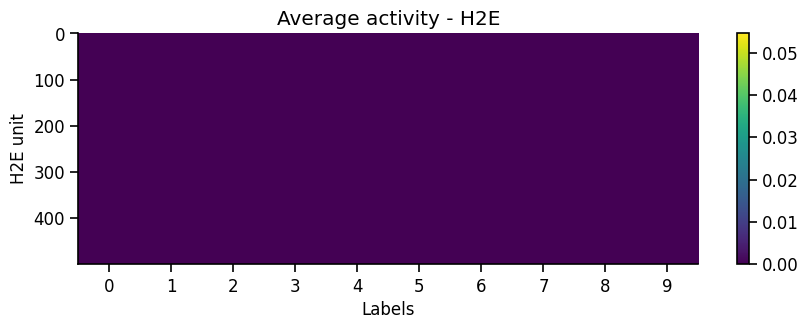

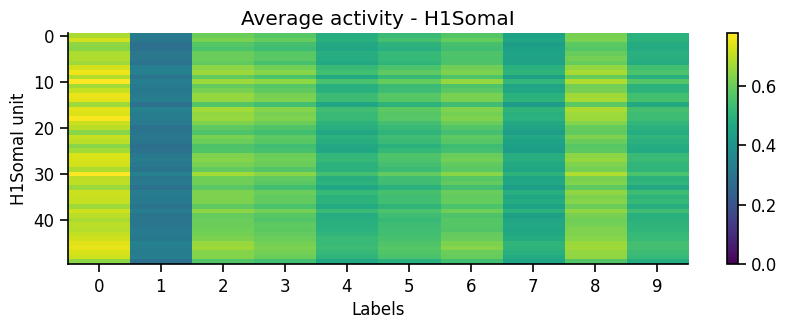

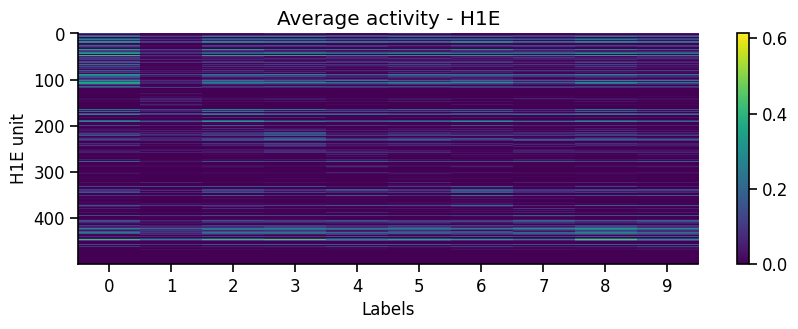

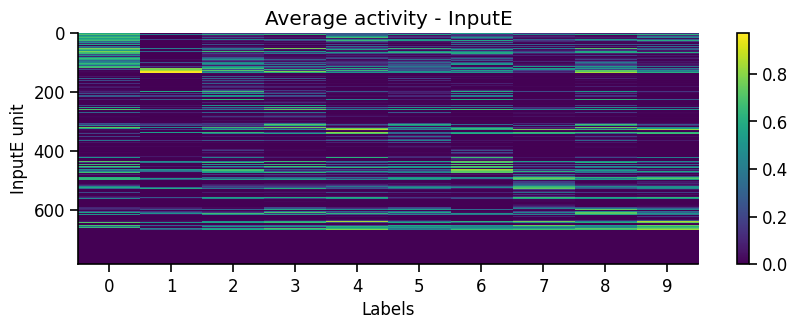

In [10]:
eiann.plot.plot_batch_accuracy(network, test_dataloader, title='', population='all')